# <u>Netflix Analysis</u>

## <u>Schema Creation</u>

## <span style="font-size: 14px; color: var(--vscode-foreground);">Below is the code used to execute the new schema names used in the Netflix Data Mart table creation:</span>

```
USE Netflix_DW;
GO

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'stg' ) -- created before other 3 to bring in dimension and fact tables through DAX Studio
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA dim AUTHORIZATION dbo;' -- executing the new schema through the database default schema authorization 
END
;

GO

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'vw' ) -- the view schema that will store views to create the dim and fact tables
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA stg AUTHORIZATION dbo;'
END
;

GO

IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name = 'dim' ) -- dim tables
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA fact AUTHORIZATION dbo;'
END


IF NOT EXISTS (SELECT * FROM sys.schemas WHERE name =  'fact'  ) -- fact tables
BEGIN
    EXEC sp_executesql N'CREATE SCHEMA vw AUTHORIZATION dbo;'
END

```

Once the schema names have been created, we can start to build the tables that will be used in our Netflix Data Mart.

## <u>Dimension Creation</u>

Listed below are the names of the seven dimension tables that will be created:

1. dim.Calendar
2. dim.Devices
3. dim.Genres
4. dim.Profiles
5. dim.Shows (Dimension to create dim.Titles)
6. dim.Movies (Dimension to create dim.Titles)
7. dim.Titles (Final dimension for shows and movies)

The tables 'dim.Shows' and 'dim.Movies' have been brought in separately containing fields for each type category(shows and movies). However, since this will create longer queries, continously require a 'UNION' or 'UNION ALL' to combine both tables, and create room for errors in the analysis, they will be combined in our final product to create dim.Titles. This way, we will have all our Netflix titles in one table and data in each column will be consistent between the two category types. 

Below is the code for creating our dimensions:

### **Dimension #1: dim.Calendar**

```
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Calendar')
BEGIN -- Beginning the table creation
    CREATE TABLE dim.Calendar( 
       PK_CalendarDate DATE NOT NULL, 
       Year INT NOT NULL, 
       Month TINYINT NOT NULL, 
       MonthName NVARCHAR(10) NULL,
       Day TINYINT NOT NULL,
       DayName NVARCHAR(10) NULL,
       Weekend NVARCHAR(3) NULL, 
       WeekofYear TINYINT NOT NULL 
       );

    ALTER TABLE dim.Calendar 
    ADD CONSTRAINT PK_Date PRIMARY KEY(PK_CalendarDate); 

END -- Ending the table creation

```

### <u>Explanation of dim.Calendar</u>

**IF NOT EXISTS SCHEMA 'dim' TABLE\_NAME = 'Calendar' :** Placing the new dimension table under the 'dim' schema and naming it

**PK\_CalendarDate :** The column all the dates from December 1st of 2013 to October 20th 2024 will fall under, DATE as the data type, and NOT NULL so each needs a date

**Year:** Column for the year within the date, INT (integer large enough for years for the data type), NOT NULL since the year is derived from the 'Date' column

**Month:** Column for the month within the date, TINYINT (integers will range from 1 to 12 for data type), NOT NULL (derived from 'Date' column)

**MonthName:** Column for the month within the date, TINYINT (integers will range from 1 to 12 for data type), NOT NULL (derived from 'Date' column)

**Day:** Column for the day of the month, TINYINT (Days ranging from 1 to 31 in a month), NOT NULL (derived from 'Date' column)

**DayName:** The name of the day of week for the day column above, NVARCHAR(10) (Days can be up to 10 letters long), NULL since we have 'Day' column can fix

**Weekend:** Column that says if it is a weekend day or not, (Y) for Yes, (N) for No, NVARCHAR(3) (only need up to 3 letters for Y and N)

**WeekofYear:** The week of the year from the date, TINYINT (integer ranging from 1-52), NOT NULL since derived from 'Date' column

**ADD CONSTRAINT PK\_Date:** Adding a primary key constraint so that each date must be unique in the table

### **Dimension #2: dim.Devices**

```
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Devices') 
BEGIN
    CREATE TABLE dim.Devices( 
       Device_ID TINYINT NOT NULL,  
       Device_Type NVARCHAR(50) NULL, 
       Times_Device_Used SMALLINT NOT NULL, 
       Device_Usage NVARCHAR(20) NULL 
       );

    ALTER TABLE dim.Devices
    ADD CONSTRAINT PK_Devices PRIMARY KEY(Device_ID); 

END

```

### <u>Explanation of dim.Devices</u>

**IF NOT EXISTS SCHEMA 'dim' TABLE\_NAME 'Devices':** Using 'dim' schema, creating the table name

**Device\_ID:** The unique identifier for each device, TINYINT since there are 46 devices, on this account most likely will stay a two digit number, NOT NULL

**Device\_Type:** The name of the device that was used, NVARCHAR(50) (Device names can be up to 50 characters long), NULL since we have Device\_ID

**Times\_Device\_Used:** The amount of times the device has been used (opening the Netflix site or app), SMALLINT (digits in thousands), NOT NULL since using measure

**Device\_Usage:** A SWITCH expression created to categorize devices by how much they were used from 'Low Usage' to 'Extreme Usage', NVARCHAR(20) (up to 20 characters), NULL (not necessary to analysis)

**ADD CONSTRAINT PK\_Devices:** Setting a primary key on the 'Device\_ID' column so that each device is unique in the table

### **Dimension #3: dim.Genres**

```
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Genres')
BEGIN
    CREATE TABLE dim.Genres(
       Genre_ID TINYINT NOT NULL,
       Genre NVARCHAR(25) NOT NULL 
       );

    ALTER TABLE dim.Genres
    ADD CONSTRAINT PK_Genre PRIMARY KEY(Genre_ID); 

END

```

### <u>Explanation of dim.Genres</u>

**IF NOT EXISTS SCHEMA 'dim' TABLE\_NAME 'Genres':** Using 'dim' schema, creating the name of the table

**Genre\_ID:** The unique identifier for each genre, TINYINT since there are 19 genres used and will likely stay two digit number, NOT NULL

**Genre:** The name of the genre for each watched, NVARCHAR(25) so genres can be up to 25 characters, NOT NULL since used often in analysis rather than ID

**ADD CONSTRAINT PK\_Genre:** Setting a primary key on the 'Genre\_ID' column so that each genre is unique

### **Dimension #4: dim.Profiles**

```
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Profiles') 
BEGIN
    CREATE TABLE dim.Profiles(
       Profile_ID TINYINT NOT NULL, 
       Profile_Name NVARCHAR(10) NOT NULL 
       );

    ALTER TABLE dim.Profiles 
    ADD CONSTRAINT PK_Profile PRIMARY KEY(Profile_ID);  

    ALTER TABLE dim.Profiles
    ADD CONSTRAINT UC_Profile UNIQUE (Profile_Name);               

END

```

### <u>Explanation of dim.Profiles</u>

**IF NOT EXISTS SCHEMA 'dim' TABLE\_NAME 'Profiles':** Using the 'dim' schema, creating the name of the table

**Profile\_ID:** The unique identifier for each profile, TINYINT since there are only 3 used and likely will stay a single digit number, NOT NULL

**Profile\_Name:** The name for each Profile, NVARCHAR(10) since only first names of family members, NOT NULL since used often in analysis rather than ID

**ADD CONSTRAINT PK\_Profile:** Setting a primary key on the 'Profile\_ID' column so that each profile is unique

**ADD CONSTRAINT UC\_Profile:** Setting the 'Profile\_Name' column to be unique, each profile must have a different name so data collected is clear for each profile

### **Dimension #5: dim.Shows**

```
--First table for the creation of our final dimension table we will use in our analysis
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Shows') 
BEGIN
    CREATE TABLE dim.Shows(
       ShowID SMALLINT NOT NULL,
       Show_Name NVARCHAR(100) NOT NULL, 
       Genre NVARCHAR(25) NOT NULL, 
       );

END                   

```

### <u>Explanation of dim.Shows</u>

**IF NOT EXISTS SCHEMA 'dim' TABLE\_NAME 'Shows':** Using the 'dim' schema and creating the name of the table

**ShowID:** The unique identifier for each show coming from the dim.Shows table in PowerBI file, will later be changed,SMALLINT (show go up to 508), NOT NULL

**Show\_Name:** The name of each show watched, NVARCHAR(100) allowing names to go up to 100 characters, NOT NULL since often used rather than ID

**Genre:** The genre that is associated to each show, NVARCHAR(25) allowing genres to be 25 characters like dim.Genres table, NOT NULL (same as dim.Genres)

**For this dimension, we will not be setting any keys since this is not the final product and will not be used in our analysis**

### **Dimension #6) dim.Movies**

```
-- Second table for the creation of our final dimension table we will use in our analysis                                                                                                                                                                   IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Movies') 
BEGIN
    CREATE TABLE dim.Movies(
       MovieID SMALLINT NOT NULL, 
       Movie_Name NVARCHAR(100) NOT NULL,
       Genre NVARCHAR(25) NOT NULL, 
       );

END                    

```

### <u>Explanation of dim.Movies</u>

**IF NOT EXISTS SCHEMA 'dim' TABLE\_NAME 'Movies':** Using the 'dim' schema, and creating the table name

**MovieID:** The unique identifier for each movie coming from the dim.Movies table in PowerBI file, will later be changed, SMALLINT(movies go up to 1409), NOT NULL

**Movie\_Name:** The name of each movie watched, NVARCHAR(100) allowing names to go up to 100 characters, NOT NULL since often used rather than ID

**Genre:** The genre that is associated to each movie, NVARCHAR(25) allowing genres to be 25 characters like dim.Genres table, NOT NULL (same as dim.Genres)

**For this dimension, we will not be setting any keys since this is not the final product and will not be used in our analysis**

### **Dimension #7) dim.Titles**

```
--The dimension table that will be created by combining dim.Shows and dim.Movies together, the table that we will be using in our analysis
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'dim' AND TABLE_NAME = 'Titles') 
BEGIN
    CREATE TABLE dim.Titles ( 
       PK_MovieShow_ID INT IDENTITY(1,1) NOT NULL, 
       Title VARCHAR(100) NOT NULL,  
       Genre NVARCHAR(25) NOT NULL, 
       Title_ID SMALLINT NULL, 
       [Type] NVARCHAR(6) NULL, 
       );

    ALTER TABLE dim.Titles
    ADD CONSTRAINT NetflixID PRIMARY KEY(PK_MovieShow_ID);                                                                                                                                                            END

```

### <u>Explanation of dim.Titles</u>

**IF NOT EXISTS SCHEMA 'dim' TABLE\_NAME 'Titles':** Using the 'dim' schema and creating the name of the table

**PK\_MovieShow\_ID:** Creating the PK\_Movie\_Show\_ID column so we are able to join both dim tables together

> Unique identifier for both movies and shows, INT(larger ID numbers), IDENTITY(1,1), starts at 1, increments by 1, NOT NULL(ID)

**Title:** The title of the movie/show, VARCHAR(100) like dim.Shows and dim.Movies, NOT NULL since often used rather than ID in analysis

**Genre:** The genre associated to each movie/show, NVARCHAR(25) like dim.Genres, NOT NULL since often used in analysis rather than Genre ID

**Title\_ID:** The new unique ID that will replace ShowID and MovieID when combining both tables, SMALLINT(like dim.Shows, dim.Movies), NULL (explanation below)

**Type:** The type of category ('Show' or 'Movie') of every title to identify each, we will create this when combining both tables, NVARCHAR(6) allowing 6 characters, NULL since not unique & can be entered manually

**ADD CONSTRAINT NetflixID:** Setting a primary key for the PK\_MovieShow\_ID column since each value must be unique

```
***In the dim.Titles table above, the Title_ID is left as 'NULL' since we will need to create these new IDs and insert them into the table during the data loading process. If we set them as 'NOT NULL', the table will require something in the fields and will create difficulties while trying to combine and insert data from dim.Shows and dim.Movies later. We will later set these as unique so that there will not be duplicates and change the type to 'NOT NULL' after the new ID's are inserted into the table.

```

We have now finished creating all of our dimension tables, and can begin creating our three fact tables.

## <u>Fact Table Creation</u>

Listed below are the three fact tables that will be created:

1. <span style="color: var(--vscode-foreground);">fact.NetflixShows (Fact table to create fact.Netflix)</span>
2. <span style="color: var(--vscode-foreground);">fact.NetflixMovies (Fact table to create fact.Netflix)</span>
3. <span style="color: var(--vscode-foreground);">fact.Netflix (Final fact table for Netflix shows and movies)</span>

Similar to the dimension tables dim.Shows and dim.Movies, having two separate fact tables creates room for error in the data analysis, creates longer queries, and with both tables holding the 'Total Duration' for each type, it is best to have them combined so that our values are consistent and easier to work with. A single fact table also aligns much better with our final dimension table dim.Titles.

Note that in the fact table creation, (required) next to 'NOT NULL' in the explanations signifies that the column is required since we will need to create relationships between our fact and dimension tables for accurate analysis.

Below is the code for creating our facts:

### **Fact #1) fact.NetflixShows**

```
-- First fact to create or final fact table we will use in the analysis
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'fact' AND TABLE_NAME = 'NetflixShows') 
BEGIN
    CREATE TABLE fact.NetflixShows ( 
        PK_Shows_ID INT IDENTITY(1,1) NOT NULL,
        [Date] DATE NOT NULL,
        Show_Name NVARCHAR(100) NOT NULL, 
        Profile_ID TINYINT NOT NULL, 
        Show_ID SMALLINT NOT NULL, 
        Genre_ID TINYINT NOT NULL, 
        Device_ID TINYINT NOT NULL, 
        Total_Duration FLOAT NOT NULL 
        );
END                      

```

### <u>Explanation of fact.NetflixShows</u>

**IF NOT EXISTS SCHEMA 'fact' TABLE\_NAME 'NetflixShows':** Using the schema 'fact', and creating the name of the table

**PK\_Shows\_ID:** Creating IDENTITY(1,1) so that each is given their own ID that will later be used to combine fact.NetflixShows and fact.NetflixMovies

> The identity of each show viewing in the fact table, will later be changed, INT (allowing for large numbers), NOT NULL (unique)

**Date:** The date of each viewing session for each profile, so that dim.Calendar will have a relationship with our final fact, DATE datatype, NOT NULL (required)

**Show\_Name:** The name of the show associated to the viewing session, will be changed, NVARCHAR(100) like dim.Shows, NOT NULL (used in analysis not ID)

**Profile\_ID:** The Profile\_ID for each viewing session, will have a relationship with dim.Profiles, TINYINT (single digit ID's), NOT NULL (required)

**Show\_ID:** The ID of each show, will be changed like 'dim.Shows' table to match the Title\_ID in the final dim, SMALLINT(up to 508 shows), NOT NULL (required)

**Genre\_ID:** The Genre\_ID associate to each viewing session, will have a relationship with dim.Devices, TINYINT (up to 19), NOT NULL (required)

**Device\_ID:** The Device\_ID associated to each viewing session, will have a relationship with dim.Devices, TINYINT(up to 46), NOT NULL (required)

**Total\_Duration:** The amount of time spent in each viewing session, FLOAT (numbers came in as decimals from PowerBI, will be casted in queries), NOT NULL (required)

**Not setting any primary or foreign keys on this table since it is not the final table we will be using**

### **Fact #2) Fact.NetflixMovies**

```
-- Second fact to create our final fact table we will use in the analysis
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'fact' AND TABLE_NAME = 'NetflixMovies')
BEGIN
    CREATE TABLE fact.NetflixMovies ( 
        PK_Movies_ID INT IDENTITY(1,1) NOT NULL, 
        [Date] DATE NOT NULL, 
        Movie_Name NVARCHAR(100) NOT NULL, 
        Profile_ID TINYINT NOT NULL, 
        Movie_ID SMALLINT NOT NULL,
        Genre_ID TINYINT NOT NULL,
        Device_ID TINYINT NOT NULL, 
        Total_Duration FLOAT NOT NULL 
    );
END                      

```

### <u>Explanation of fact.NetflixMovies</u>

**IF NOT EXISTS SCHEMA 'fact' TABLE\_NAME 'NetflixMovies':** Using schema name 'fact', and creating the name of the table

**PK\_Movies\_ID:** Creating IDENTITY(1,1) so that each is given their own ID that will later be used to combine fact.NetflixShows and fact.NetflixMovies

> The identity of each movie viewing in the fact table, will later be changed, INT (allowing for large numbers), NOT NULL (unique)

**Date:** The date of each viewing session for each profile, so that dim.Calender will have a relationship with our final fact, DATE datatype, NOT NULL (required)

**Movie\_Name:** The name of the movie associated to the viewing session, will be changed, NVARCHAR(100) like dim.Movies, NOT NULL (used in analysis not ID)

**Profile\_ID:** The Profile\_ID for each viewing session, will have a relationship with dim.Profiles, TINYINT (single digit ID's), NOT NULL (required)

**Movie\_ID:** The ID of each movie, will be changed like 'dim.Movies' table to match the Title\_ID in the final dim, SMALLINT(up to 1401 movies), NOT NULL (required)

**Genre\_ID:** The Genre\_ID associated to each viewing session, will have a relationship with dim.Genres, TINYINT(up to 19), NOT NULL (required)

**Device\_ID:** The Device\_ID associated to each viewing session, will have a relationship with dim.Devices, TINYINT(up to 46), NOT NULL (required)

**Total\_Duration:** The amount of time spent in each viewing session, FLOAT (numbers came in as decimals from PowerBI), NOT NULL (necessary for analysis)

**Not setting any primary or foreign keys on this table since it is not the final table we will be using**

### **Fact #3) Fact.Netflix**

```
--The fact table that will be created by combining fact.NetflixShows and fact.NetflixMovies together, the table we will be using in our analysis
IF NOT EXISTS (SELECT * FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA = 'fact' AND TABLE_NAME = 'Netflix') 
BEGIN
    CREATE TABLE fact.Netflix (
        PK_Netflix_ID INT IDENTITY(1,1) NOT NULL, 
        [Date] DATE NOT NULL, 
        Title NVARCHAR(100) NOT NULL, 
        Profile_ID TINYINT NOT NULL, 
        Title_ID SMALLINT NOT NULL, 
        Genre_ID TINYINT NOT NULL,
        Device_ID TINYINT NOT NULL, 
        Total_Duration FLOAT NOT NULL
;

    ALTER TABLE fact.Netflix 
    ADD CONSTRAINT PK_Netflix PRIMARY KEY (PK_Netflix_ID); 

    ALTER TABLE fact.Netflix
    ADD CONSTRAINT FK_NETFLIXtoCAL
    FOREIGN KEY ([Date])                 
    REFERENCES dim.Calendar(PK_CalendarDate);    

    ALTER TABLE fact.Netflix
    ADD CONSTRAINT FK_NETFLIXtoPROFILE
    FOREIGN KEY (Profile_ID)             
    REFERENCES dim.Profiles(Profile_ID);

    ALTER TABLE fact.Netflix
    ADD CONSTRAINT FK_NETFLIXtoDEVICE
    FOREIGN KEY (Device_ID)              
    REFERENCES dim.Devices(Device_ID);
     
    ALTER TABLE fact.Netflix
    ADD CONSTRAINT FK_NETFLIXtoGENRE
    FOREIGN KEY (Genre_ID)                
    REFERENCES dim.Genres (Genre_ID);ADD CONSTRAINT FK_NETFLIXtoGENRE
    
END                                       

```

### <u>Explanation of fact.Netflix</u>

**IF NOT EXISTS SCHEMA 'fact' TABLE\_NAME 'Netflix':** Using the schema 'fact', creating the name for the table

**PK\_Netflix\_ID:** The unique identifier for both movie/show viewings, INT(larger numbers), IDENTITY(1,1), start at 1, increment by 1, NOT NULL(unique)

**Date:** The date for each viewing session for movies/shows, connected to dim.Calendar, DATE datatype, NOT NULL (required)

**Title:** The name for the movie/show, NVARCHAR(100) (matching fact & dim tables NVARCHAR characters), NOT NULL (required)

**Profile\_ID:** The Profile\_ID associated to each viewing session, connected to dim.Profiles, TINYINT(single digit numbers), NOT NULL (required)

**Title\_ID:** The new column that will replace both the 'Show\_ID' and 'Movie\_ID' columns in dim.Shows and dim.Movies, SMALLINT (1909 total titles), NOT NULL (required for relationship to dim.Titles)

**Genre\_ID:** The Genre\_ID associated to each viewing session, connected to dim.Genres, TINYINT (double digits), NOT NULL (required)

**Device\_ID:** The Device\_ID associated to each viewing session, connected to dim.Devices, TINYINT (double digits), NOT NULL (required)

**Total\_Duration:** The amount of time spent watching shows/movies each viewing session, FLOAT (same type as previous facts), NOT NULL (necessary for analysis)

**ADD CONSTRAINT PK\_Netflix:** Setting the primary key on the PK\_Netflix\_ID viewing session so each is unique

**ADD CONSTRAINT FKNETFLIXtoCAL:** Connecting the dim.Calendar table through a foreign key to the fact.Netflix table 'Date' column

**ADD CONSTRAINT FKNETFLIXtoPROFILE:** Connecting the dim.Profiles table through a foreign key to the fact.Netflix table 'Profile\_ID' column

**ADD CONSTRAINT FKNETFLIXtoDEVICE:** Connecting the dim.Devices table through a foregn key to the fact.Netflix table 'Device\_ID' column

**ADD CONSTRAINT FKNETFLIXtoGENRE:** Connecting the dim.Genres table through a foreign key to the fact.Netflix table 'Genre\_ID' column

```
***For the foreign key that connects dim.Titles to fact.Netflix, we will wait to create it afterwards along with our unique identifier once the tables are combined, this way there are no restrictions when building the tables in the data loading process.
```

Our fact tables are now created and ready for the data loading process.

## <u>EDR Diagram of Netflix DataMart</u>

Below is an image constructed to show the final product of our dimension and fact creation. Note that the two fact and two dimension tables we will not be using are placed below since they are only temporary tables in the Netflix Data Mart:

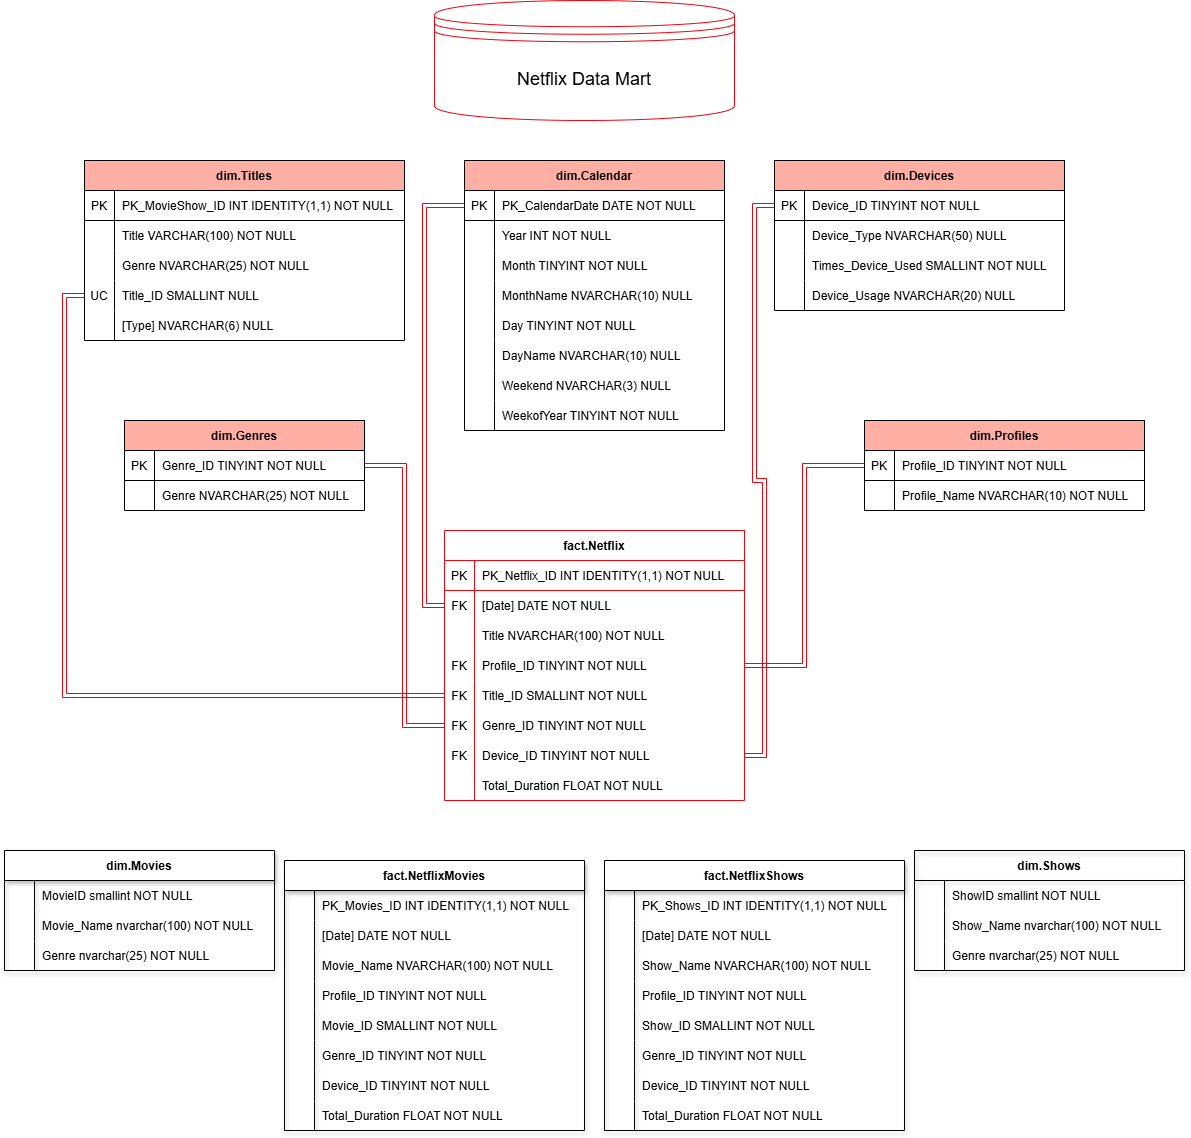

## <u>Data Loading</u>

Now that our dimension and fact tables are made, we can insert data from the staging process into them. For all of our dimensions except for dim.Titles, we can insert data from the 'stg' schemas directly into the tables. For our facts, we will narrow down the information through a view before inserting data into the fact.NetflixShows and fact.NetflixMovies to save storage in our DataMart and generate faster results. From there, we can start the creation of our new fact table, fact.Netflix. The process of creating our final dimension and fact table will be clearly indicated below in the data loading processes.

We will first start with telling SSMS the database we want to work in, which is the new database "Netflix\_DW" that we created at the beginning of the Netflix Data Mart process:

```
USE Netflix_DW; GO -- 'GO' to tell SQL to separate the batch of SQL statements from 'USE'

```

Once SSMS recognizes the database, we can start inserting data into the newly created tables from our old tables we brought in through DAX studio under the schema 'stg' :

**\*\*Note that 'GO' is placed between each table to separate query batches from one another in the data loading process**

### **Data Loading dim.Shows**

```
GO
INSERT INTO dim.Shows(ShowID,Show_Name,Genre)
	SELECT stg.ID 
		  ,stg.ShowName
		  ,stg.Genre
	FROM stg.Shows stg
;
GO
```

### <u>Explanation of dim.Shows</u>

**INSERT INTO dim.Shows(ShowID,Show_Name,Genre):** 'INSERT INTO' to tell SQL to insert the following data into the dimension we created, the columns specified in order to match the columns entered below 

**Stg.ID:** Indicating the table 'stg', then the column that comes from within the stg.Shows table 'ID', so this column will be inserted into 'ShowID' in the new dim.Shows table

**Stg.ShowName:** Indicating 'stg', the column 'ShowName' from the stg. table to insert into the 'Show_Name' column in the new dim.Shows table

**stg.Genre:** Indicating 'stg', the column 'Genre from the stg. table to insert into the 'Genre' column in the new dim.Shows table

**Ending with FROM stg.Shows, telling the query where the data is coming from**

**Ending with GO to separate query batch**

### **Data Loading dim.Movies**

```
INSERT INTO dim.Movies(MovieID, Movie_Name,Genre)
	SELECT stg.Movie_ID
		  ,stg.MovieName
		  ,stg.Genre
	FROM stg.Movies stg
;
GO

```

### <u>Explanation of dim.Movies</u>

**INSERT INTO dim.Movies(MovieID,Movie_Name,Genre):** 'INSERT INTO' to tell SQL to insert the following data into the dimension we created, the columns specified in order to match the columns entered below

**Stg.Movie_ID:** Indicating 'stg', taking the column 'Movie_ID' from stg table then inserting into the new column 'MovieID' in the dim.Movies table

**Stg.MovieName:** Indicating 'stg', taking the column 'MovieName' from the stg table then inserting into the new column 'Movie_Name' in dim.Movies table

**Stg.Genre:** Indicating 'stg', taking the new column 'Genre' from the stg table then inserting into the new column 'Genre' in dim.Movies table

**Ending with FROM stg.Movies, telling the query where the data is coming from**

**Ending with GO to separate query batch**

The two dimension tables above are temporary as we will later put them in a view to insert data into our table 'dim.Titles'.

### **Data Loading dim.Calendar**

```
INSERT INTO dim.Calendar(PK_CalendarDate,Year,Month,MonthName,Day,DayName,Weekend,WeekofYear)
    SELECT stg.[Date]
          ,stg.Year
          ,stg.Month
          ,stg.MonthName
          ,stg.Day
          ,stg.DayName
          ,stg.Weekend
          ,stg.WeekofYear
    FROM stg.Calendar stg
;

GO

```

### <u>Explanation of dim.Calendar</u>

**INSERT INTO dim.Calendar(PK_CalendarDate,Year,Month,MonthName)...:** Telling SQL which dimension to insert the data into, the columns are in order from our new table to match the columns below

**Stg.Date:** Indicating the 'stg' table, then the column 'Date' from the 'stg' table to insert it into the new dim.Calendar table column 'PK_CalendarDate'

**Stg.Year:** Indicating 'stg', then the column 'Year' from the 'stg' table to insert it into the new dim.Calendar table column 'Year'

**Stg.Month:** Indicating 'stg', then the column 'Month' from the 'stg' table to insert it into the new dim.Calender table column 'Month'

**Stg.MonthName:** Indicating 'stg', then the column 'MonthName' from the 'stg' table to insert it into the new dim.Calender table column 'MonthName'

**Stg.Day:** Indicating 'stg', then the column 'Day' from the 'stg' table to insert it into the new dim.Calendar table column 'Day'

**Stg.DayName:** Indicating 'stg', then the column 'DayName' from the 'stg' table to insert it into the new dim.Calendar table column 'DayName'

**Stg.Weekend:** Indicating 'stg', then the column 'Weekend' from the 'stg' table to insert it into the new dim.Calendar table column 'Weekend'

**Stg.WeekofYear:** Indicating 'stg', then the column 'WeekofYear' from the 'stg' table to insert it into the new dim.Calendar table column 'WeekofYear'

**Ending with FROM stg.Movies, telling the query where the data is coming from**

**Ending with GO to separate query batch**



### **Data Loading dim.Profiles**

```
INSERT INTO dim.Profiles(Profile_ID, Profile_Name)
	SELECT stg.Profile_ID
		  ,stg.[Profile_Name]
	FROM stg.Profiles stg

;
GO

```

### <u>Explanation of dim.Profiles</u>

**INSERT INTO dim.Profiles(Profile_ID,Profile_Name):** Telling SQL which dimension to insert the data into, the columns are in order from our new table to match the columns below

**Stg.Profile_ID:** Indicating the 'stg' table, then the column 'Profile_ID' from the 'stg' table to insert it into the 'Profile_ID' column in dim.Profiles

**Stg.[Profile_Name]:** Indicating 'stg', then the column '[Profile_Name]' from the 'stg' table to insert it into the 'Profile_Name' column in dim.Profiles

**Ending with FROM stg.Profiles, telling the query where the data is coming from**

**Ending with GO to separate query batch**

### **Data Loading dim.Genres**

```
INSERT INTO dim.Genres(Genre_ID,Genre)
	SELECT stg.Genre_ID
		,stg.Genre
	FROM stg.Genres stg

;
GO
```

### <u>Explanation of dim.Genres</u>

**INSERT INTO dim.Genres(Genre_ID,Genre):** Telling SQL which dimension to insert the data into, the columns are in order from our new table to match the columns below

**Stg.Genre_ID:** Indicating the 'stg' table, then the column 'Genre_ID' from the 'stg' table to insert into the 'Genre_ID' column in dim.Genres

**Stg.Genre:** Indicating 'stg', then the column 'Genre' from the 'stg' table to insert into the 'Genre' column in dim.Genres

**Ending with FROM stg.Genres, telling the query where the data is coming from**

**Ending with GO to separate query batch**

### **Data Loading dim.Devices**

```
INSERT INTO dim.Devices(Device_ID, Device_Type,Times_Device_Used,Device_Usage)
    SELECT stg.Device_ID
        ,stg.Device_Type
        ,stg.[Times_Device_Used]
        ,stg.[Device_Usage]
    FROM stg.Devices stg

;
GO

```

### <u>Explanation of dim.Devices</u>

**INSERT INTO dim.Devices(Device_ID,Device_Type,Times_Device_Used,Device_Usage):** Telling SQL which dimension to insert the data into, the columns are in order from our new table to match the columns below

**Stg.Device_ID:** Indicating the 'stg' table, then the column 'Device_ID' from the 'stg' table to insert into the column 'Device_ID' in the dim.Devices table

**Stg.Device_Type:** Indicating the 'stg' table, then column 'Device_Type' from the 'stg' table to insert into the column 'Device_Type' in the dim.Devices table

**Stg.[Times_Device_Used]:** Indicating the 'stg' table, then the column 'Times_Device_Used' table to insert into the new column 'Times_Device_Used' in the dim.Devices table

**Stg.Device_Usage:** Indicating 'stg', then the column 'Device_Usage' from the 'stg' table to insert into the new column 'Device_Usage' in the dim.Devices table

**Ending with FROM stg.Profiles, telling the query where the data is coming from**

**Ending with GO to separate query batch**

Now that we have done all of our dimensions except for dim.Titles, we will start on building the views for our fact table. In order to create our final dimension, we need all of the tables pulled in from DAX studios so we are able to pull the data together in the correct order for the data loading sheet to run properly.

To decrease the size of our final fact table, since currently both fact.NetflixShows and fact.NetflixMovies equal out to 25,716 rows, we will condense them both by selecting specific rows from both to create smaller tables to combine to make fact.Netflix. The views are below:

### **Creating vw.fNetflixMovies**

```
CREATE OR ALTER VIEW vw.fNetflixMovies AS
SELECT [Date] as 'Date'
    ,Profile_ID 
    ,Movie_ID
    ,Genre_ID
    ,Device_ID
    ,SUM(Duration) as 'Total Duration'
FROM stg.fNetflixMovies
GROUP BY [Date],Profile_ID,Movie_ID,Genre_ID,Device_ID
;
```
```
GO
```

### <u>Explanation of vw.fNetflixMovies</u>

**CREATE OR ALTER VIEW vw.fNetflixMovies AS:** Telling SSMS to create a new view with the title 'vw.fNetflixMovies', 'ALTER' is included in case we want to make any adjustments to the query later on

**[Date]:** To make sure we can use all time measures in our dim.Calender in our analysis, we will include the 'Date' column from stg.fNetflixMovies, the original 'stg' table from DAX Studios

**[Profile_ID]:** The 'Profile_ID' column will be necessary in our fact table to have a relationship with dim.Profiles and identify who watched what show/movie, coming from the 'stg' table from DAX Studios

**[Movie_ID]:** The 'Movie_ID' column will be replaced, however to create our new 'Title_ID' column in our fact table it is necessary to be able to identify each movie viewing session, 'stg' table from DAX Studios

**Genre_ID:** The 'Genre_ID' column is necessary for our fact table to have a relationship to dim.Genres and so we know the genre of each title in the analysis, 'stg' table from DAX Studios

**Device_ID:** The 'Device_ID' column is included since we will need a relationship to the dim.Devices table, so we are able to match each show/movie to the device it was streamed on, 'stg' table from DAX Studios

**SUM(Duration) as 'Total Duration':** We will use the aggregation 'SUM' on the 'Duration' column to roll up the rows in our fact.NetlfixMovies table, 'stg' table from DAX Studios

**GROUP BY [Date],Profile_ID,Movie_ID...:** Grouping by everything outside of our aggregation (SUM) so the values in our Duration are properly matched and grouped to the other fields in the fact table



### **Creating vw.fNetflixShows**

```
CREATE OR ALTER VIEW vw.fNetflixShows AS
SELECT [Date] as 'Date'
    ,Profile_ID
    ,Show_ID
    ,Genre_ID
    ,Device_ID
    ,SUM(Duration) as 'Total Duration'
FROM stg.fNetflixShows 
GROUP BY [Date],Profile_ID,Show_ID,Genre_ID,Device_ID;

```
```
GO
```

### <u>Explanation of vw.fNetflixShows</u>

**CREATE OR ALTER VIEW vw.fNetflixShows AS:** Telling SSMS to create a new view with the title 'vw.fNetflixShows', 'ALTER' is included in case we want to make any adjustments to the query later on

**[Date]:** To make sure we can use all time measures in our dim.Calender in our analysis, we will include the 'Date' column from stg.fNetflixShows, the original 'stg' table from DAX Studios

**[Profile_ID]:** The 'Profile_ID' column will be necessary in our fact table to have a relationship with dim.Profiles and identify who watched what show/movie, coming from the 'stg' table from DAX Studios

**[Show_ID]:** The 'Show_ID' column will be replaced, however to create our new 'Title_ID' column in our fact table it is necessary to be able to identify each movie viewing session, 'stg' table from DAX Studios

**Genre_ID:** The 'Genre_ID' column is necessary for our fact table to have a relationship to dim.Genres and so we know the genre of each title in the analysis, 'stg' table from DAX Studios

**Device_ID:** The 'Device_ID' column is included since we will need a relationship to the dim.Devices table, so we are able to match each show/movie to the device it was streamed on, 'stg' table from DAX Studios

**SUM(Duration) as 'Total Duration':** We will use the aggregation 'SUM' on the 'Duration' column to roll up the rows in our fact.NetlfixShows table, 'stg' table from DAX Studios

**GROUP BY [Date],Profile_ID,Show_ID...:** Grouping by everything outside of our aggregation (SUM) so the values in our Duration are properly matched and grouped to the other fields in the fact table

Our views are now created and stored in the 'Views' folder in our database. Our two views have taken 25,716 rows of data and rolled them up into a total of 8,452 rows (2,745 in vw.fNetflixMovies and 5,707 in vw.fNetflixShows), this will create a much easier fact table for our Data Mart. Before returning to our dim.Titles table, we will insert these views into our fact.NetflixShows and fact.NetflixMovies tables:

### **Data Loading fact.NetflixShows**

```
INSERT INTO fact.NetflixShows ([Date], Show_Name, Profile_ID, Show_ID, Genre_ID, Device_ID, Total_Duration)
SELECT 
    vw.[Date],
    sh.Show_Name,
    vw.Profile_ID,
    vw.Show_ID,
    vw.Genre_ID,
    vw.Device_ID,
    SUM(vw.[Total Duration]) AS Total_Duration
FROM 
    vw.fNetflixShows vw
INNER JOIN 
    dim.Shows sh ON vw.Show_ID = sh.ShowID
GROUP BY 
    vw.[Date], sh.Show_Name, vw.Profile_ID, vw.Show_ID, vw.Genre_ID, vw.Device_ID;                                                                                                                    GO

```

### <u>Explanation of fact.NetflixShows</u>

**INSERT INTO fact.NetflixShows([Date],Show_Name,Profile_ID,...):** Telling SSMS which table the following data will be inserted into, the columns are in order from our new table to match the table below

**vw[Date]:** Indicating the 'vw' table that the data is coming from, then the '[Date]' column from the 'vw' table to insert into the column '[Date]' in the fact.NetflixShows table

**sh.Show_Name:** Indicating the 'sh' table that we inner joined (dim.Shows), taking the column 'Show_Name' from dim.Shows and inserting it into our 'Show_Name' column in the fact.NetflixShows table

**vw.Profile_ID:** Indicating the 'vw' table, then the 'Profile_ID' column from the 'vw' table to insert into the column 'Profile_ID' in the fact.NetflixShows table

**vw.Show_ID:** Indicating the 'vw' table, then the 'Show_ID' column from the 'vw' table to insert into the column 'Show_ID' in the fact.NetflixShows table

**vw.Genre_ID:** Indicating the 'vw' table, then the 'Genre_ID' column from the 'vw' table to insert into the column 'Genre_ID' in the fact.NetflixShows table

**vw.Device_ID:** Indicating the 'vw' table, then the 'Device_ID' column from the 'vw' table to insert into the column 'Device_ID' in the fact.NetflixShows table

**SUM(vw.[Total Duration]) AS Total_Duration:** Indicating the aggregation (SUM) from the 'vw.' table, naming it 'Total_Duration', then taking it from the 'vw' table and inserting it into 'Total_Duration' in the fact.NetflixShows table

**FROM vw.NetflixShows vw:** The view we are pulling the data from 

**INNER JOIN dim.Shows sh ON vw.Show_ID = sh.Show_ID:** Joining the vw.fNetflixShows table and dim.Shows table in order to bring in the 'sh.Show_Name' field in our fact.NetflixShows table

**GROUP BY vw.[Date],sh.Show_Name,vw.Profile_ID,...:** Grouping by everything outside of our aggregation (SUM) so the values in our 'Total_Duration' are properly matched and grouped to the other fields in the fact.NetflixShows table

### **Data Loading fact.NetflixMovies**

```
INSERT INTO fact.NetflixMovies([Date],Movie_Name,Profile_ID,Movie_ID,Genre_ID,Device_ID,Total_Duration)
    SELECT vw.[Date]
        ,mv.Movie_Name
        ,vw.Profile_ID
        ,vw.Movie_ID
        ,vw.Genre_ID
        ,vw.Device_ID
        ,SUM([Total Duration]) as 'Total_Duration'
    FROM vw.fNetflixMovies vw
    INNER JOIN dim.Movies mv
    ON vw.Movie_ID = mv.MovieID
    GROUP BY vw.[Date], mv.Movie_Name, vw.Profile_ID, vw.Movie_ID, vw.Genre_ID, vw.Device_ID;                                                                                                           GO

```

### <u>Explanation of fact.NetflixMovies</u>

**INSERT INTO fact.NetflixMovies([Date],Movie_Name,Profile_ID,...):** Telling SSMS which table the following data will be inserted into, the columns are in order from our new table to match the table below

**vw[Date]:** Indicating the 'vw' table that the data is coming from, then the '[Date]' column from the 'vw' table to insert into the column '[Date]' in the fact.NetflixMovies table

**sh.Show_Name:** Indicating the 'sh' table that we inner joined (dim.Shows), taking the column 'Show_Name' from dim.Shows and inserting it into our 'Show_Name' column in the fact.NetflixMovies table

**vw.Profile_ID:** Indicating the 'vw' table, then the 'Profile_ID' column from the 'vw' table to insert into the column 'Profile_ID' in the fact.NetflixMovie table

**vw.Movie_ID:** Indicating the 'vw' table, then the 'Movie_ID' column from the 'vw' table to insert into the column 'Show_ID' in the fact.NetflixMovie table

**vw.Genre_ID:** Indicating the 'vw' table, then the 'Genre_ID' column from the 'vw' table to insert into the column 'Genre_ID' in the fact.NetflixMovie table

**vw.Device_ID:** Indicating the 'vw' table, then the 'Device_ID' column from the 'vw' table to insert into the column 'Device_ID' in the fact.NetflixMovie table

**SUM(vw.[Total Duration]) AS Total_Duration:** Indicating the aggregation (SUM) from the 'vw.' table, naming it 'Total_Duration', then taking it from the 'vw' table and inserting it into 'Total_Duration' in   the fact.NetflixMovies table

**INNER JOIN dim.Movies mv ON vw.Movie_ID = mv.Movie_ID:** Joining the vw.fNetflixMovies table and dim.Movies table in order to bring in the 'mv.Movie_Name' field in our fact.NetflixMovies table

**GROUP BY vw.[Date],mv.Movie_Name,vw.Profile_ID,...:** Grouping by everything outside of our aggregation (SUM) so the values in our 'Total_Duration' are properly matched and grouped to the other fields in the fact.NetflixMovies table

All of the data from the tables that were brought in from DAX Studios are now loaded into the tables we made in our schemas creation except for dim.Titles and fact.Netflix. We will now use both dim.Shows and dim.Movies to create our dim.Titles first, then the fact.NetflixShows and fact.NetflixMovies tables to create fact.Netflix. The purpose of loading our others first is because of the new 'Title\_ID' and 'Type' columns we will be creating. Before combining both the dim and fact tables, we can now clearly see where in the table will be changed in our dim.Titles, and updated in our fact.Netflix.

To begin creating dim.Titles, we will drop the current columns 'ShowID' and 'MovieID' from dim.Shows and dim.Movies:

### **Dropping and Creating Title\_ID**

```
ALTER TABLE dim.Shows
DROP COLUMN ShowID;

ALTER TABLE dim.Movies
DROP COLUMN MovieID;

ALTER TABLE dim.Shows
ADD Title_ID SMALLINT NULL;

ALTER TABLE dim.Movies
ADD Title_ID SMALLINT NULL;

```
```
GO
```

### <u>Explanation of Dropping and Creating Title_ID</u>

**ALTER TABLE dim.Shows, DROP COLUMN ShowID:** The statement 'ALTER' telling SSMS we want to edit a table, followed by the table name, then the 'DROP COLUMN' statement to delete the column 'ShowID' from the dim.Shows table

**ALTER TABLE dim.Movies, DROP COLUMN MovieID:** The statement 'ALTER' telling SSMS we want to edit a table, followed by the table name, then the 'DROP COLUMN' statement to delete the column 'MovieID' from the dim.Movies table

**ALTER TABLE dim.Shows, ADD Title_ID SMALLINT NULL:** The statement 'ALTER' telling SSMS we want to edit a table, followed by the table name, then the 'ADD' statement to create a new column in the table named 'Title_ID', SMALLINT (up to 508 ID's in the dim.Shows table), 'NULL' to be able to insert our new 'Title_ID' field once the dim.Titles is created, otherwise it won't create the table once we try to insert data from our view we will create

**ALTER TABLE dim.Movies, ADD Title_ID SMALLINT NULL:** The statement 'ALTER' telling SSMS we want to edit a table, followed by the table name, then the 'ADD' statement to create a new column in the table named 'Title_ID', SMALLINT (up to 1409 ID's in the dim.Movies table), 'NULL' to be able to insert our new 'Title_ID' field once the dim.Titles is created, otherwise it won't create the table once we try to insert data from our view we will create

Once we have dropped and added in the new 'Title\_ID' columns to our dim.Movies and dim.Shows dimensions, we can create the view that will union these both together to create dim.Titles:

### **Creating vw.dim**

```
CREATE OR ALTER VIEW vw.dim AS
SELECT mv.Movie_Name as 'Title'
    ,mv.Genre
    ,mv.Title_ID
FROM dim.Movies mv
UNION ALL
SELECT sh.Show_Name as 'Title'
    ,sh.Genre
    ,sh.Title_ID
FROM dim.Shows sh;                                                                                                                                                                                  GO

```

### <u>Explanation of Creating vw.dim</u>

**CREATE OR ALTER VIEW vw.dim AS:** Telling SSMS we are creating a view, 'ALTER' included in case we need to make any adjustments

**mv.Movie_Name as 'Title':** Indicating 'mv' for the dim.Movies table, taking the column 'Movie_Name' and naming it 'Title' so the column in dim.Shows matches for the creation of dim.Titles

**mv.Genre:** Indicating 'mv' for dim.Movies, taking the column 'Genre' from dim.Movies that will go in our new dim.Titles dimension

**mv.Title_ID:** Indicating 'mv' for dim.Movies, taking the new column we just created above that is currently filled with 'NULL' that will be updated with new ID's

**FROM dim.Movies mv:** Indicating the data is coming from dim.Movies

**UNION ALL:** The 'UNION ALL' statement is going to combine both dim.Shows and dim.Movies in our view to create one table with name, genre, and ID columns appended together

**Show_Name as 'Title':** Indicating 'sh' for the dim.Shows table, taking the column 'Show_Name' and naming it 'Title' so the column in dim.Movies matches for the creation of dim.Titles

**Sh.Genre:** Indicating 'sh' for dim.Shows, taking the column 'Genre' from dim.Shows that will go in our new dim.Titles dimension

**Sh.Title_ID:** Indicating 'sh' for dim.Shows, taking the new column we just created above that is currently filled with 'NULL' that will be updated with new ID's

**FROM dim.Shows sh:** Indicating the data is coming from dim.Shows

We will now take the view we just created (vw.dim) and insert it into our dim.Titles dimension:

### **Dimension #7: dim.Titles**

```
INSERT INTO dim.Titles(Title,Genre)
SELECT Title
    ,Genre
FROM vw.dim;

UPDATE dim.Titles
SET Title_ID = 10000 + PK_MovieShow_ID;

UPDATE dim.Titles
SET [Type] = 'Movie'
WHERE Title_ID < 11402;

UPDATE dim.Titles
SET [Type] = 'Show'
WHERE Title_ID >= 11402;

```
```
GO
```

### <u>Explanation of dim.Titles</u>

**INSERT INTO dim.Titles(Title,Genre):** Telling SQL what table we will insert data into, the columns are in order from dim.Titles to match the columns below from our view vw.dim

**Title:** Taking the 'Title' column from vw.dim that will be inserted into the new column 'Title' in dim.Titles

**Genre:** Taking the 'Genre' column from vw.dim that will be inserted into the new column 'Genre' in dim.Titles

Once we execute the new data going into dim.Titles, we can now update our new 'Title_ID' column 

**UPDATE dim.Titles:** Using the statmenet 'UPDATE' to insert new data into the dim.Titles table

**SET Title_ID = 10000 + PK_MovieShow_ID:** These numbers will be our new ID's by taking the 'PK_MovieShow_ID' column we created earlier in our schema creation that start at 1 and increment by 1, and adding on 10,000 

Now that the Title_ID column contains data, we will update our 'Type' column we made during our schema creation. This column will indicate whether the row is a 'Movie' or a 'Show' in the data analysis. Since we know how many movies and shows were in each table, we can look at the new dim.Titles table and find the Title_ID 11402, since dim.Movies was first in our created view, the movies were placed before the shows. We know that there were 1402 rows in our dim.Movies table so 1401 + 10000 = 11401, this will be the last row where the movies and shows separate and where our 'Type' column will change categories.

**UPDATE dim.Titles:** Using the statmenet 'UPDATE' to insert new data into the dim.Titles table

**SET [Type] = 'Movie':** Indicating the category we will be setting in the new column

**WHERE Title_ID < 11402:** Using the 'WHERE' statement so SSMS will recognize where we are comparing our new column to, and <11402 so that all 'Title_ID's below 11402 will be set to the category 'Movie' in the column

**UPDATE dim.Titles:** Using the statmenet 'UPDATE' to insert new data into the dim.Titles table

**SET [Type] = 'Show':** Indicating the category we will be setting in the new column

**WHERE Title_ID => 11402:** Using the 'WHERE' statement so SSMS will recognize where we are comparing our new column to, and => 11402 so that all 'Title_ID's equal to and above 11402 will be set to the category 'Show' in the column


Our dim.Titles table is now created and ready for our analysis. All that is left is taking fact.NetflixMovies and fact.NetflixShows, combining them into a view similar to the process we just did and creating our final fact.Netflix table.

### **Creating vw.Fact**

```
CREATE OR ALTER VIEW vw.Fact AS
SELECT sh.[Date]
    ,sh.Show_Name as 'Title'
    ,sh.Profile_ID
    ,sh.Show_ID as 'Netflix_ID'
    ,sh.Genre_ID
    ,sh.Device_ID
    ,sh.Total_Duration
FROM fact.NetflixShows sh
UNION ALL
SELECT mv.[Date]
    ,mv.Movie_Name as 'Title'
    ,mv.Profile_ID
    ,mv.Movie_ID as 'Netflix_ID'
    ,mv.Genre_ID
    ,mv.Device_ID
    ,mv.Total_Duration
FROM fact.NetflixMovies mv;

```
```
GO
```

### <u>Explanation of vw.Fact</u>

**CREATE OR ALTER VIEW vw.Fact AS:** Telling SSMS we are creating a view, 'ALTER' included in case we need to make any adjustments

**Sh.[Date]:** Indicating 'sh' for the fact.NetflixShows table, the '[Date] column that will indicate show viewing sessions

**Sh.Profile_ID:** Indicating 'sh', the 'Profile_ID' column from the fact.NetflixShows table associated to each shows viewing session

**Sh.Show_ID:** Indicating 'sh', the 'Show_ID' column from the fact.NetflixShows table, renaming it 'Netflix_ID' so it will have the same name as our fact.NetflixMovies below (This is where our Title_ID column is)

**Sh.Genre_ID:** Indicating 'sh', the 'Genre_ID' column from the fact.NetflixShows table associated to each shows viewing session

**Sh.Device_ID:** Indicating 'sh', the 'Device_ID' column from the fact.NetflixShows table associated to each shows viewing session

**Sh.Total_Duration:** Indicating 'sh', the 'Total_Duration column from the fact.NetflixShows table (our SUM aggregation) of the amount of time spent in each viewing session

**From fact.NetflixShows sh:** Telling SSMS where the data is coming from

**UNION ALL:** The 'UNION ALL' statment is going to append both our fact.NetflixShows and fact.NetflixMovies tables together with all columns present in our query combined

**Mv.[Date]:** Indicating 'mv' for the fact.NetflixMovies table, the '[Date] column that will indicate show viewing sessions

**Mv.Profile_ID:** Indicating 'mv', the 'Profile_ID' column from the fact.NetflixMovies table associated to each shows viewing session

**Mv.Show_ID:** Indicating 'mv', the 'Movie_ID' column from the fact.NetflixMovies table, renaming it 'Netflix_ID' so it will have the same name as our fact.NetflixMovies above (Title_ID column is here)

**Mv.Genre_ID:** Indicating 'mv', the 'Genre_ID' column from the fact.NetflixMovies table associated to each shows viewing session

**Mv.Device_ID:** Indicating 'mv', the 'Device_ID' column from the fact.NetflixMovies table associated to each shows viewing session

**Mv.Total_Duration:** Indicating 'mv', the 'Total_Duration column from the fact.NetflixMovies table (our SUM aggregation) of the amount of time spent in each viewing session

**From fact.NetflixMovies mv:** Telling SSMS where the data is coming from

Once we run and create or vw.Fact, we can load the data from our new view into our final table fact.Netflix:

### **Data Loading fact.Netflix**

```
INSERT INTO fact.Netflix([Date], Title, Profile_ID, Title_ID, Genre_ID, Device_ID, Total_Duration)
SELECT 
    f.[Date],
    f.Title,
    f.Profile_ID,
    f.Netflix_ID,
    f.Genre_ID,
    f.Device_ID,
    (f.[Total_Duration])
FROM 
    vw.Fact f                                                                                                                                                                                       GO

```

### <u>Explanation of Data Loading fact.Netflix</u>

**INSERT INTO fact.Netflix([Date],Title,Profile_ID,...):** Telling SSMS which table we are inserting data into and the columns in order to match the table below

**f.[Date]:** Indicating 'f' for the vw.Fact view, the column '[Date]' from the view we created above 

**f.Title:** Indicating 'f', the column 'Title' from our view with all the movie and show titles 

**f.Profile_ID:** Indicating 'f', the column 'Profile_ID from our view with all the profile ID's associated to each viewing session

**f.Netflix_ID:** Indicating 'f', the column 'Netflix_ID' from our view with all the show and movie ID's we will update to our 'Title_ID' column from dim.Titles

**f.Genre_ID:** Indicating 'f', the column 'Genre_ID' from our view with all the show and movie genres associated to each viewing session

**f.Device_ID:** Indicating 'f', the column 'Device_ID' from our view with all the device ID's associated to each viewing session for both shows and movies

**f([Total_Duration]):** Indicating 'f', the column 'Total_Duration from our view with all the durations associated to each viewing session for both shows and movies

**FROM vw.Fact f:** Telling SSMS the data is coming from our vw.Fact view

Our data is now loaded into our final fact.Netflix table. All of the data loading processes are now complete and the last task is to update our 'Netflix\_ID' in our fact.Netflix table to have the same values as our dim.Titles table so they can have a relationship and have a key and unique constraint between them:

### **Updating and Final Keys**

```
UPDATE fact.Netflix
SET fact.Netflix.Title_ID = dim.Titles.Title_ID
FROM fact.Netflix
INNER JOIN dim.Titles ON fact.Netflix.Title = dim.Titles.Title;

ALTER TABLE dim.Titles
ALTER COLUMN Title_ID SMALLINT NOT NULL;

ALTER TABLE dim.Titles
ADD CONSTRAINT UC_Title UNIQUE (Title_ID);

ALTER TABLE fact.Netflix
ADD CONSTRAINT PK_NETFLIXtoTITLES 
FOREIGN KEY (Title_ID) 
 REFERENCES dim.Titles(Title_ID); 
```

### <u>Explanation of Updating and Final Keys</u>

**UPDATE fact.Netflix:** Telling SSMS which table we want to update

**SET fact.Netflix.Title_ID = dim.Titles.Title_ID':** Setting our column 'Title_ID' that we created in our fact.Netflix schema creation to contain the same values as our dim.Titles table.

**FROM fact.Netflix:** The table we are setting the data equal to

**INNER JOIN dim.Titles ON fact.Netflix.Title = dim.Titles.Title:** Joining the two tables so SSMS can recognize where the 'Title_ID' column it is pulling data from is, using their common columns 'Title' 

**----------------------------------------------------------------------**

**Now we will add our constraints and update the dim.Titles table to have 'NOT NULL' instead of NULL for values under 'Title_ID**

**ALTER TABLE dim.Titles:** Telling SSMS which table we want to alter

**ALTER COLUMN Title_ID SMALLINT NOT NULL:** The statment 'ALTER COLUMN' so we can change the column type, 'Title_ID' the specific column, SMALLINT (datatype of column,) and NOT NULL to replace the current type NULL

**-----------------------------------------------------------------------**

**Once we have changed the type, we can add on our keys**

**ALTER TABLE dim.Titles:** Telling SSMS which table we want to alter

**ADD CONSTRAINT UC_Title UNIQUE (Title_ID):** The statement 'ADD CONSTRAINT' so SSMS knows we are creating a key, 'UC_Title is the name of the constraint, 'UNIQUE' so that every data row must be unique in the column, (Title_ID) is the name of the column we are placing the constraint on

**ALTER TABLE fact.Netflix:** Telling SSMS which table we want to alter

**ADD CONSTRAINT PK_NETFLIXtoTITLES:** The statement 'ADD CONSTRAINT' so SSMS knows we are creating a key, 'PK_NetflixtoTITLES' is the name of the constraint

**FOREIGN KEY (Title_ID):** Connecting the dim.Titles table to the fact.Netflix table through a foreign key

**REFERENCES dim.Titles(Title_ID):** Telling SSMS which table the foreign key references and (Title_ID) so that it knows which column the foreign key is placed on


We have officially completed creating our Netflix Data Mart and it is now ready to use for our analysis which will be shown in Sequel Server Reporting Services.